In [570]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns
import optuna

In [571]:
# Read in the data
data_path = '../../preprocessing/data'

# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')
# Columns in A but not in test_A






A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

In [572]:
B.columns

Index(['pv_measurement', 'date_forecast',
       'super_cooled_liquid_water:kgm2_interval_1',
       'super_cooled_liquid_water:kgm2_interval_2',
       'super_cooled_liquid_water:kgm2_interval_3',
       'super_cooled_liquid_water:kgm2_interval_4',
       'sun_elevation_cloud_interaction_interval_1',
       'sun_elevation_cloud_interaction_interval_2',
       'sun_elevation_cloud_interaction_interval_3',
       'sun_elevation_cloud_interaction_interval_4',
       'total_radiation_interval_1', 'total_radiation_interval_2',
       'total_radiation_interval_3', 'total_radiation_interval_4',
       'diffuse_rad:W_interval_1', 'diffuse_rad:W_interval_2',
       'diffuse_rad:W_interval_3', 'diffuse_rad:W_interval_4',
       'diffuse_rad_1h:J_interval_1', 'diffuse_rad_1h:J_interval_2',
       'diffuse_rad_1h:J_interval_3', 'diffuse_rad_1h:J_interval_4',
       'direct_rad:W_interval_1', 'direct_rad:W_interval_2',
       'direct_rad:W_interval_3', 'direct_rad:W_interval_4',
       'direct_rad

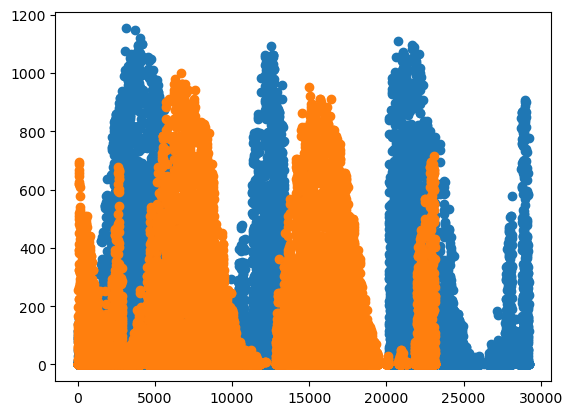

In [573]:
def find_constant_rows(dataframe, column_name):
    # Get the indices where value changes
    change_indices = dataframe[column_name].diff().ne(0).cumsum()
    # Filter groups with size over 24 and get their indices
    constant_indices = change_indices.value_counts()[change_indices.value_counts() > 24].index
    # Get the rows to remove
    rows_to_remove = change_indices.isin(constant_indices).loc[lambda x: x].index
    return rows_to_remove

# Get indices of rows where 'pv_measurement' is constant for more than 24 times
rows_to_remove = find_constant_rows(B, 'pv_measurement')

# Remove those rows from the dataframe
B = B.drop(rows_to_remove)

plt.scatter(B.index, B['pv_measurement'])

# Get indices of rows where 'pv_measurement' is constant for more than 24 times
rows_to_remove = find_constant_rows(C, 'pv_measurement')

# Remove those rows from the dataframe
C = C.drop(rows_to_remove)

plt.scatter(C.index, C['pv_measurement'])



In [574]:
A = A[A['date_forecast'].dt.month.isin([4, 5, 6, 7, 8, 9])]
unique_days = A['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

B = B[B['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
unique_days = B['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
unique_days = C['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
X_train_A = X_train_A.drop(columns='date_forecast')
X_train_B = X_train_B.drop(columns='date_forecast')
X_train_C = X_train_C.drop(columns='date_forecast')
X_val_A = X_val_A.drop(columns='date_forecast')
X_val_B = X_val_B.drop(columns='date_forecast')
X_val_C = X_val_C.drop(columns='date_forecast')

In [575]:
from catboost import CatBoostRegressor

# Assuming 'A' is a pandas DataFrame with the necessary data and 'month' and 'pv_measurement' columns.
# Splitting the data as provided in the question.
train_A = A[A['month'].isin([3, 4, 5, 7, 8, 9])]
val_A = A[A['month'].isin([6])]
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

# Define the model with the specified parameters
model_A = CatBoostRegressor(
    subsample=0.99,
    rsm=0.9,
    random_strength=0.3,
    min_data_in_leaf=10,
    learning_rate=0.09,
    l2_leaf_reg=6,
    grow_policy='SymmetricTree',
    iterations=400,
    depth=10,
    border_count=17,
    bootstrap_type='Bernoulli',
    early_stopping_rounds=23,
    sampling_frequency='PerTreeLevel'
)

# Train the model
model_A.fit(X_train_A, y_train_A, eval_set=(X_val_A, y_val_A), verbose=False)

# The model is now trained with the given dataset and parameters.





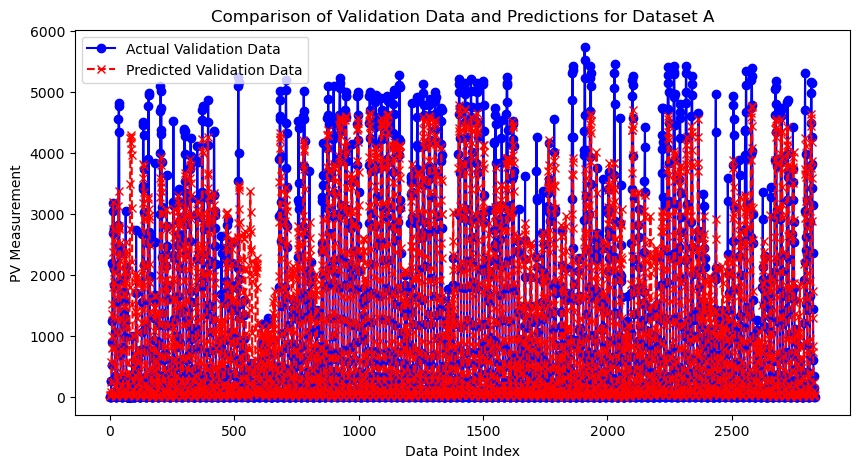

In [576]:
import matplotlib.pyplot as plt

# Assuming model_A is the trained CatBoostRegressor model from previous context and 'val_A' is your validation set.

# Reset the index of the validation set for plotting
val_A_reset_index = val_A.reset_index(drop=True)

# Get predictions for the validation set
predictions_A = model_A.predict(X_val_A)

# Plot the validation targets against the predicted values
plt.figure(figsize=(10, 5))
plt.plot(val_A_reset_index['pv_measurement'].values, label='Actual Validation Data', color='blue', marker='o')
plt.plot(predictions_A, label='Predicted Validation Data', color='red', linestyle='--', marker='x')
plt.title('Comparison of Validation Data and Predictions for Dataset A')
plt.xlabel('Data Point Index')
plt.ylabel('PV Measurement')
plt.legend()
plt.show()


In [577]:
from catboost import CatBoostRegressor

# Dataset B preparation and training
train_B = B[B['month'].isin([3, 4, 5, 7, 8, 9])]
val_B = B[B['month'].isin([6])]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

model_B = CatBoostRegressor(
    subsample=0.99,
    rsm=0.9,
    random_strength=0.3,
    min_data_in_leaf=20,
    learning_rate=0.09,
    l2_leaf_reg=6,
    grow_policy='SymmetricTree',
    iterations=700,
    depth=10,
    border_count=17,
    bootstrap_type='Bernoulli',
    early_stopping_rounds=23,
    sampling_frequency='PerTreeLevel'
)

model_B.fit(X_train_B, y_train_B, eval_set=(X_val_B, y_val_B), verbose=False)


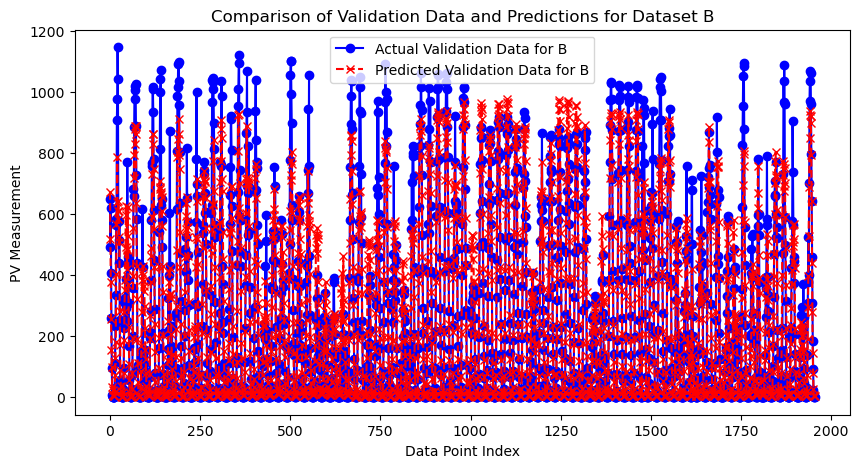

In [578]:
# Make predictions on the validation set for dataset B
predictions_B = model_B.predict(X_val_B)

# Reset index for the validation set for B
val_B_reset_index = val_B.reset_index(drop=True)

# Plotting validation and predictions for dataset B
plt.figure(figsize=(10, 5))
plt.plot(val_B_reset_index['pv_measurement'].values, label='Actual Validation Data for B', color='blue', marker='o')
plt.plot(predictions_B, label='Predicted Validation Data for B', color='red', linestyle='--', marker='x')
plt.title('Comparison of Validation Data and Predictions for Dataset B')
plt.xlabel('Data Point Index')
plt.ylabel('PV Measurement')
plt.legend()
plt.show()

In [579]:

# Dataset C preparation and training
train_C = C[C['month'].isin([3, 4, 5, 7, 8, 9])]
val_C = C[C['month'].isin([6])]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

model_C = CatBoostRegressor(
    subsample=0.99,
    rsm=0.9,
    random_strength=0.3,
    min_data_in_leaf=20,
    learning_rate=0.09,
    l2_leaf_reg=6,
    grow_policy='SymmetricTree',
    iterations=700,
    depth=10,
    border_count=17,
    bootstrap_type='Bernoulli',
    early_stopping_rounds=23,
    sampling_frequency='PerTreeLevel'
)

model_C.fit(X_train_C, y_train_C, eval_set=(X_val_C, y_val_C), verbose=False)


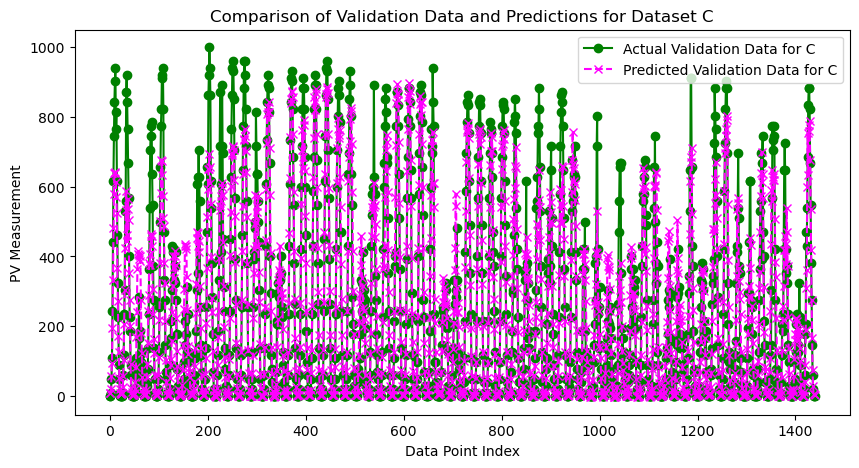

In [580]:
# Make predictions on the validation set for dataset C
predictions_C = model_C.predict(X_val_C)

# Reset index for the validation set for C
val_C_reset_index = val_C.reset_index(drop=True)

# Plotting validation and predictions for dataset C
plt.figure(figsize=(10, 5))
plt.plot(val_C_reset_index['pv_measurement'].values, label='Actual Validation Data for C', color='green', marker='o')
plt.plot(predictions_C, label='Predicted Validation Data for C', color='magenta', linestyle='--', marker='x')
plt.title('Comparison of Validation Data and Predictions for Dataset C')
plt.xlabel('Data Point Index')
plt.ylabel('PV Measurement')
plt.legend()
plt.show()

In [582]:
pred_A = model_A.predict(test_A)
pred_B = model_B.predict(test_B)
pred_C = model_C.predict(test_C)

# save predictions to csv
pred_A = pd.DataFrame(pred_A)
pred_B = pd.DataFrame(pred_B)
pred_C = pd.DataFrame(pred_C)
predicitions = pd.concat([pred_A, pred_B, pred_C])
predicitions.to_csv('predictions.csv', index=False)
